# Develop your first convolutional neural network for image classification
### A bit of background. The mnist dataset is a widely used dataset to teach the fundamentals of deep learning on images. The original dataset is a large number of hand written numbers, and many models have been benchmarked on this dataset (https://en.wikipedia.org/wiki/MNIST_database). 
### In January 2023, Yang et. al. published a medical mnist dataset consisting of standardized medical images. They provide datasets from many fields (pathology, radiology, derm, etc) and it is a great resource to get started building models for classification of medical images using neural networks.
### We have adapted their code (https://github.com/MedMNIST/MedMNIST) to train a simple 2 layer CNN for the classification of their images. This is a much more advanced process than the other projects in this module, but we hope it will be a good introduction to arttifical intelligence in computer vision.

### **[Load Dependecies](#install-and-import-dependecies)**<br>
### **[Define Initial Parameters](#define-some-initial-parameters)**<br>
### **[Load Data](#load-data)**<br>
### **[Visualize Data](#visualize)**<br>
### **[Build CNN](#build-cnn)**<br>
### **[Define Train and Test Functions](#define-train-and-test-functions)**<br>
### **[Train and Test](#train-and-test)**<br>
### **[Visualize Results](#visualize-results)**<br>
### **[Recap](#recap)**<br>

## Install and import dependecies


### You may have some of these already loaded, but we included just in case 
### We are using pytorch for the machine learning stuff, but you can try other libraries (tensorflow, keras, etc)

In [ ]:
!pip install medmnist
!pip install torch torchvision 
!pip install numpy
!pip install matplotlib


In [51]:
# Import Dependecies

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO, Evaluator

## Define Some Initial Parameters 


### These are all important hyperparameters involved in machine learning. We start out by just laying some 'ground rules' for the rest of our work

In [75]:
# the data_flag you un comment will be the dataset you work wit. Explore different types!
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
# data_flag = 'dermamnist'
# data_flag = 'retinamnist'
# data_flag = 'breastmnist'
# data_flag = 'bloodmnist'
# data_flag = 'tissuemnist'
# data_flag = 'organamnist'
# data_flag = 'organcmnist'
# data_flag = 'organsmnist'

# set this to true to download the images
download = True

# define the some parameters for the neural network. In python, capital letters represent a constant and it is good practice to define constants in this format. 
# we have given brief descriptions of what some of these parameters mean, but you may want to google for a more comprehensive understanding
# number of complete passes through dataset. Higher value can increase accuracy at the cost of time
NUM_EPOCHS = 5
# the number of data samples that are processed together as a group during a single iteration
BATCH_SIZE = 128
# interval with which we display results
LOG_INTERVAL = 10
# learning rate- a complicated topic at its core, but this number is an important hyperparameter for the optimizer (which we define later)
lr = 0.001

# get some initial information from the dataset
info = INFO[data_flag]
task = info['task']

n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## Load Data


### Load the medmnist dataset into our code using the torchvision library. 
### Theres a lot going on here, but in brief all this is doing is getting the data from the internet and putting it into a format with which we can train our model with
### It is worth understanding some of these points in detail through further self teaching

In [76]:
# preprocessing setup- wil be used make the data into tensors (data structure for ML) and normalize the tensors
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# define hwo you want to load the data and split into train and test sets. It is very very important you never have training data in your testing data, 
# as this will not allow you to know if your model is learning
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# encapsulate data into dataloader form using all the predefined stuff
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# we dont want to shuffle the testing data so we can compare the testing results consistently after each epoch
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /Users/georgienahass/.medmnist/pathmnist.npz
Using downloaded and verified file: /Users/georgienahass/.medmnist/pathmnist.npz


## Visualization


### We can look at some of the metadata of the dataset as well as check out some of the actual pictures to see what we are working with

In [77]:
# lets check out some of the metadata of the medmnist set we just loaded 
print(train_dataset)
print("===================")
print(test_dataset)
# the goal of this model is to correctly classify each image in the dataset as belonging to one of the labels 
# If you are using the pathmnist dataset, this means whetehr it is adipose, background, lymphocytes, mucus, etc..

Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: /Users/georgienahass/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-

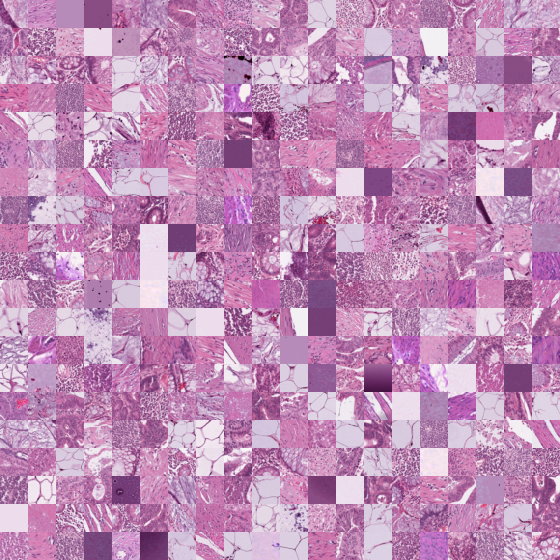

In [78]:
# Visualize some actual pictures
# show a 20x20 matrix of images (400 pictures)
train_dataset.montage(length=20)

## Build CNN


### This model has 2 convolutional layers (nn.conv2d) and 2 fully connected layers (nn.linear)
### The '__init__' method describes all the stuff the network will use, and the 'forward' method defines the overall architecture of the model
### We include some operations such as dropout, max pooling, and relu activation functions. These are all critical components of neural networks and we suggest you read up on them to really understand what is happening here. Try pasting this code into ChatGPT and asking it to teach you!
### This is a *very* simple model, but it is good to start with the basics!

In [79]:
# define a simple CNN model
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)

        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1024 , 50)
        self.fc2 = nn.Linear(50, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        # x = F.relu(F.max_pool2d(self.conv1(x), 2)) # this line of code does the same thing as the previous 3
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
    
        # x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # this line of code does the same thing as the previous 4- written in long form for understanding 
        x = x.view(x.size(0), -1)  # Reshape tensor to [batch_size, num_features_before_fc]
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
    

# make an object of the Net Class using the number of input channels and the number of output channels as inputs
# here, input channels is 3 (RGB) and n_classes is 9 (9 different diagnoses of the medMnist dataset)
model = Net(in_channels=n_channels, num_classes=n_classes)
optimizer = optim.Adam( model.parameters(), lr=lr)


## Define train and test functions


### These are the functions that handle the 'logistics' of training and testing our model. 
### Too much to unpack succinctly, but this is the basic outline, We have tried to provide helpful comments in the code to explain the lines, but you may need to research further 

In [80]:
# define the loss function
criterion = nn.CrossEntropyLoss()        
def train(epoch, network, optimizer):
    #put network in training mode
    network.train()
    train_loss = 0
    correct = 0 
    #iterate through training data once per epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        #data, target = data.cuda(), target.cuda() # add this line when using gpu
        #set optimizer to 0- very important to ensure that the gradients do not accumulate across iterations of batches
        optimizer.zero_grad()
        output = network(data)
        # get predicted class label for each input image in the batch  max and index gives the index (i.e. the label)
        pred = output.data.max(1, keepdim=True)[1]  
        # update correct variable      
        correct += pred.eq(target.data.view_as(pred)).sum().item()
        # calculate the loss using the adams optimzer and the predicted output vs the target
        loss = criterion(output, target.squeeze(1))
        # update the train loss
        train_loss += loss.item()
        #collect new gradient and back propagate into network parameters using optimizer.step
        loss.backward()
        optimizer.step()
        #log data at pre set steps defined by log interval. This is strictly for visual monitoring of progress
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    accuracy = correct / len(train_loader.dataset)
    train_loss_return = train_loss / len(train_loader)
    return train_loss_return, accuracy

def test(network):
    network.eval()
    test_loss = 0
    correct = 0
    # do not need to use gradient here as evaluating and not updating the weights
    with torch.no_grad():
        for data, target in test_loader:
            #data, target = data.cuda(), target.cuda() # add this line if using gpu
            # send test data into network
            output = network(data)
            criterion = nn.CrossEntropyLoss()
            loss =criterion(output, target.squeeze(1))
            # update test_loss based on the returned tensor from the network.
            test_loss += loss.item()
            # get predicted class label for each input image in the batch  max and index gives the index (i.e. the label)
            pred = output.data.max(1, keepdim=True)[1]
            # convert the target data to the same size of the prediction, and then sum up the value of the tensor
            # pytorch--> true ==1 so can sum the whole tensor to get the correct values and update the model 
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    accuracy = correct / len(test_loader.dataset)       
    test_loss_return = test_loss / len(test_loader)
    # test_losses.append(test_loss)

    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss_return, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    
    return test_loss_return, accuracy


## Train and test


### Use the functions we just defined to train and test the model!
### We also store the outputs (loss and accuracy) in some lists to visualize later

In [81]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_accuracy = train(epoch, model, optimizer)
    test_loss, test_accuracy = test(model)
    # Append the loss and accuracy values
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

Train Epoch: 1 [0/89996 (0%)]	Loss: 2.216218
Train Epoch: 1 [1280/89996 (1%)]	Loss: 2.070178
Train Epoch: 1 [2560/89996 (3%)]	Loss: 1.896165
Train Epoch: 1 [3840/89996 (4%)]	Loss: 1.848392
Train Epoch: 1 [5120/89996 (6%)]	Loss: 1.667843
Train Epoch: 1 [6400/89996 (7%)]	Loss: 1.662897
Train Epoch: 1 [7680/89996 (9%)]	Loss: 1.619604
Train Epoch: 1 [8960/89996 (10%)]	Loss: 1.604454
Train Epoch: 1 [10240/89996 (11%)]	Loss: 1.631877
Train Epoch: 1 [11520/89996 (13%)]	Loss: 1.557228
Train Epoch: 1 [12800/89996 (14%)]	Loss: 1.582265
Train Epoch: 1 [14080/89996 (16%)]	Loss: 1.547705
Train Epoch: 1 [15360/89996 (17%)]	Loss: 1.582902
Train Epoch: 1 [16640/89996 (18%)]	Loss: 1.699532
Train Epoch: 1 [17920/89996 (20%)]	Loss: 1.374159
Train Epoch: 1 [19200/89996 (21%)]	Loss: 1.553743
Train Epoch: 1 [20480/89996 (23%)]	Loss: 1.510354
Train Epoch: 1 [21760/89996 (24%)]	Loss: 1.326460
Train Epoch: 1 [23040/89996 (26%)]	Loss: 1.354489
Train Epoch: 1 [24320/89996 (27%)]	Loss: 1.342164
Train Epoch: 1 [25

## Visualize Results
### Use the matplotlib library to visualize our final data and assess how well our model did! We want to *minimize* loss and *maximize* accuracy

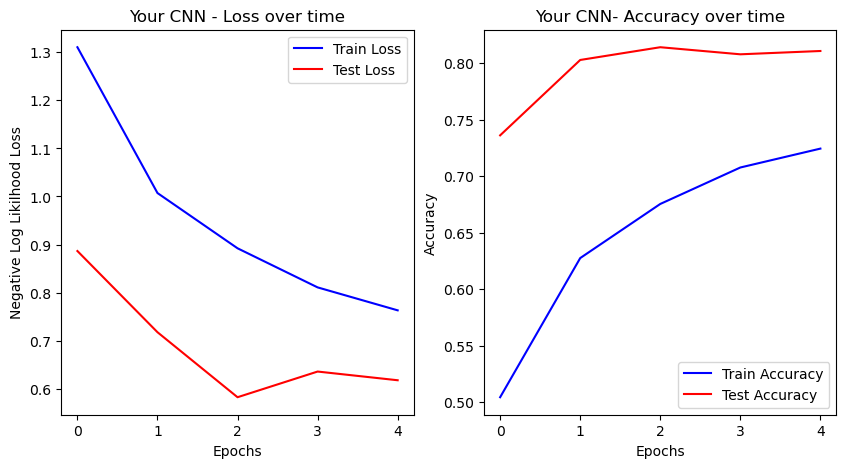

In [82]:

# Plot the loss and accuracy values
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss',color='blue')
plt.plot(test_losses, label='Test Loss', color = 'red')
plt.title(f'Your CNN - Loss over time')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likilhood Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color = 'blue')
plt.plot(test_accuracies, label='Test Accuracy', color = 'red')
plt.title(f'Your CNN- Accuracy over time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()



plt.show()


## Recap

### Congratulations! You built your first model for AI in computer vision. after 5 epochs we get around 72% accuracy. Not too bad! But definitely room to improve. Getting above 90% on this dataset is certainly possible, and the best way to do this would be to try building different CNN archictures. Feel free to give this a try! Try increasing the number of convolutional layers or fully connected layers! The best way to get better is to practice. If you get a *scary* error, just google it! 
### There is obviously much, much more to learn about AI and computer vision, but we hope this provided a framework for you to start building on, or at the very least begin to understand how AI works when you read about it in the news or on a paper. Happy learning!